## 1. Motivation
### 1.1 Introduction to the dataset
 
### 1.2 Reason for choosing this dataset
### 1.3 The goal for the end user's experience

## 2. Basic stats
### 2.1 Packeges used
In orded to be able to achieve the final goal, the following packegers were being used.

In [129]:
!pip install python-louvain
from bs4 import BeautifulSoup
from collections import Counter
import community as community_louvain
import datetime
from fa2 import ForceAtlas2
import json
from math import isnan
import matplotlib.pyplot as plt
import networkx as nx
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords as sw
from nltk.corpus import words
from nltk.probability import FreqDist
#from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WhitespaceTokenizer
import numpy as np
import pandas as pd
import pickle
from PIL import Image
import re
import seaborn as sns
import wptools
import wordcloud
from wordcloud import ImageColorGenerator, WordCloud

# Only activated for the website
# plt.style.use('dark_background') # remove / comment

ZODIAC_SIGNS = ['Aquarius', 'Aries', 'Cancer', 'Capricorn', 'Gemini', 'Leo', 'Libra', 'Pisces', 'Sagittarius', 'Scorpio', 'Taurus', 'Virgo']
ZODIAC_ELEMENTS = ['Water', 'Fire', 'Earth', 'Air']

color_legend_zodiac = {
    'Aries': '#FFFF66', 'Taurus': 'gold', 'Gemini': 'orange', 'Cancer': 'orangered', 'Leo': 'crimson', 'Virgo': 'mediumvioletred', 'Libra': 'darkviolet', 'Scorpio': 'mediumblue', 'Sagittarius': 'royalblue', 'Capricorn': 'c', 'Aquarius': 'green', 'Pisces': 'limegreen'}

# todo choose pretty colors for the elements
color_legend_element = {'Air': 'yellow', 'Fire': 'orange', 'Water': 'blue', 'Earth': 'green'}


You should consider upgrading via the 'c:\users\lulka\anaconda3\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lulka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lulka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\lulka\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## TODO Intro (similar to the website, explain basics of zodiac signs to give some context)

### 2.2 Dataset
### Upload the dataframe
After all the data is gathered (see ./DataGathering.ipynb), the dataset is loaded, deleting the duplicates and the rows that contain NaN values.
### 2.3 Dataset cleaning and extraction


In [120]:
# Load the dataframe with all of our data
df = pd.read_pickle('./datafiles/full_df.pickle')

# Remove NaN and duplicates
df.drop_duplicates(subset ="Handle", inplace = True)
df.dropna(inplace = True)
df.reset_index(drop=True, inplace=True)

df.head()

,Name,WikiLink,Handle,Birthday,ZodiacSign,Element,Tweets,Following,Id
0,Barack Obama,Barack Obama,@barackobama,1961-08-04,Leo,Fire,"['More than anyone else, I wrote my book for y...","[1330457336, 3383203552, 30354991, 3157910605,...",813286
1,Justin Bieber,Justin Bieber,@justinbieber,1994-03-01,Pisces,Water,"['Happy 5 years of Purpose', 'Rockin Around th...","[1096286154930843648, 30973513, 3320745074, 23...",27260086
2,KATY PERRY,Katy Perry,@katyperry,1984-10-25,Scorpio,Water,['❗️KATYCATS N KATYCLOWNTS❗️I’ve been cookin’ ...,"[939091, 180535644, 4185877812, 3564127636, 62...",21447363
3,Rihanna,Rihanna,@rihanna,1988-02-20,Pisces,Water,"['The faces of history makers, boundary breake...","[1116089461480153088, 480769467, 401802609, 11...",79293791
4,Cristiano Ronaldo,Cristiano Ronaldo,@cristiano,1985-02-05,Aquarius,Air,"['@DjokerNole not bad bro🤔😅', 'P𝐫𝐞𝐩𝐚𝐫𝐚𝐝𝐨𝐬! 🇵🇹💪...","[1324677118660280320, 4793420675, 108557129919...",155659213


Our dataframe consists of todonumber of rows and the following columns:
- Name: 
- Wikilink: Link to the users Wikipedia page
- Handle: Twitter username
- Birthday: Date of birth (based on the Wikipedia page)
- ZodiacSign: Zodiac sign (based on the birthday)
- Element: (based on the zodiac sign)
- Tweets: last 50 tweets since ????todo
- Following: id of the twitter accounts that the user follows
- Id: id of the twitter account

### Creation of the network
A directed graph is generated. In our network, the nodes are the twitter usernames of our celebrities and the links are the representation if a user follows the other. We also add attributes to the nodes as we are going to need them later.

In [122]:
# Create the nodes of the graph
G = nx.DiGraph()
G.add_nodes_from(df.Handle)

# Set the attributes of the nodes
nx.set_node_attributes(G, dict(zip(df.Handle, df.ZodiacSign)), "zodiac")
nx.set_node_attributes(G, dict(zip(df.Handle, df.Element)), "element")
nx.set_node_attributes(G, dict(zip(df.Handle, df.Id)), "id")

# Create the links of the graph
user_names_by_id = {value : key for (key, value) in nx.get_node_attributes(G, 'id').items()}

for user in user_names_by_id.values():
    for following in df.loc[df['Handle'] == user]["Following"]:
        for friend in following:
            try:
                friend_name = user_names_by_id[friend]
                G.add_edge(user, friend_name)
            except:
                pass
            
print("The number of nodes in the network is: ", G.number_of_nodes())
print("The number of links in the network is: ", G.number_of_edges())

The number of nodes in the network is:  2151
The number of links in the network is:  124721


We want to make sure that we only work with connected nodes, as the isolated are not going to be useful for our network.

In [124]:
# Remove isolates
isolated = list(nx.isolates(G))
G.remove_nodes_from(isolated)

# Select giant connected component
largest_cc = max(nx.weakly_connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()

# Create undirected graph
U = G.to_undirected()

print("The number of nodes in the network is: ", G.number_of_nodes())
print("The number of links in the network is: ", G.number_of_edges())

The number of nodes in the network is:  2037
The number of links in the network is:  124721


### Visualization of the network
First we need to calculate the position and size of the nodes using force Atlas.

In [130]:
# Display the network using forceAtlas

# Color the nodes based on the zodiac sign
node_color_zodiac = []
for node in G.nodes(data=True):
    node_color_zodiac.append(color_legend_zodiac[node[1]['zodiac']])

    
# Color the nodes based on the element 
node_color_element = []
for node in G.nodes(data=True):
    node_color_element.append(color_legend_element[node[1]['element']])



# Size the nodes based on their degree
node_size = [v*0.5 for v in dict(G.degree).values()]

# Configure forceAtlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=False)

# Obtain the positions
positions = forceatlas2.forceatlas2_networkx_layout(U, pos=None, iterations=200)

KeyboardInterrupt: 

We color the nodes based on the element of the user

In [ ]:
plt.figure(figsize = (16,16))


# PLot the undirected graph
nx.draw_networkx_nodes(U, pos=positions, alpha=0.7, node_size=node_size, node_color=node_color_element)
nx.draw_networkx_edges(U, pos=positions, alpha=0.3,width=0.2)


# Caption figure
plt.figtext(
    0.5, 
    0.1, 
    'Fig. todo: Visual representation of the celebrity network G using force Atlas 2 positions', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

# Create legend

for label in color_legend_element:
    plt.plot([0],[0],color=color_legend_element[label],label=label)
plt.legend()
plt.axis('off')
plt.show()

Before going deep into the analysis of the network, the distribution of the zodiac signs is plotted 

In [ ]:
# Plot zodiac distribution

zodiacs = [value for key, value in nx.get_node_attributes(G, 'zodiac').items()]
counts_zodiac = Counter(zodiacs)

# Create histrogram with a bin for each zodiac sign
plt.figure(figsize = (15,5))
plt.bar(range(len(counts_zodiac)), list(counts_zodiac.values()), align='center')
plt.xticks(range(len(counts_zodiac)), list(counts_zodiac.keys()))

# Format plot
plt.title("Zodiac distribution")
plt.ylabel("Frequency")
plt.xlabel("Zodiac")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO: Zodiac distribution in the twitter network.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

As shown above, the distribution of the zodiac signs is pretty even. 

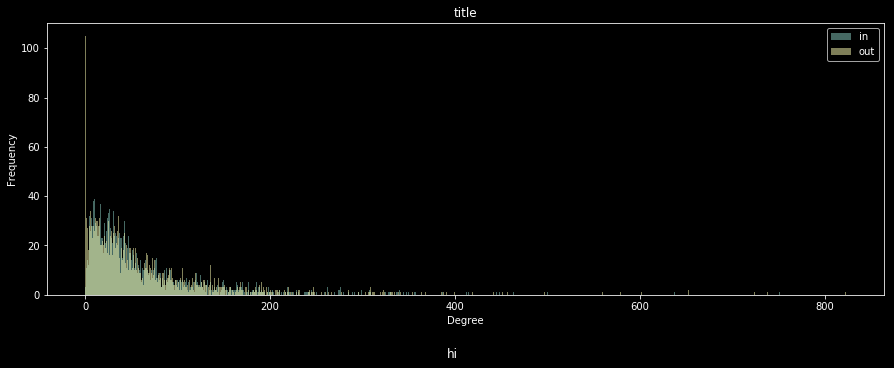

In [116]:
# Plot the in and out degree distribution

plt.figure(figsize = (15,5))

in_degree = [value for key, value in list(G.in_degree())]
plt.hist(in_degree, bins=range(np.min(in_degree), np.max(in_degree)+1), alpha=0.5, label="in")

out_degree = [value for key, value in list(G.out_degree())]
plt.hist(out_degree, bins=range(np.min(out_degree), np.max(out_degree)+1), alpha=0.5, label="out")

plt.title("title")
plt.ylabel("Frequency")
plt.xlabel("Degree")
plt.legend()
plt.figtext(
    0.5, 
    -0.05, 
    'hi', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

The in-degree distribution can be interpreted as the popularity of the user among the other users of the network, while out-degree might tell us something about the personality of the user as we usually tend to follow accounts we find interesting.

We can see that out of all of the nodes in our network, more than one hundred of them have 0 out-degree. This can be seen in users like Taylor Swift (@taylorswift). This is quite a common thing to do among artist if we quickly skimm famous artist accounts, so it was expected to appear in our network. 

todo: add something like this:
The in-degree disribution has a much higher maximum than the out-degree distribution, and a higher frequency of very low degrees. This is because a few very popular characters exist, but many are unpopular and seldom referenced. In contrast, out-degree does have some pages with a low out-degree, presumably from pages with minimal content, but most pages reference quite a number of other characters. The lower maximum values of out-degree is because even the extensive pages don't have the need for several houndred different character references, as this would be too extensive for a Wikipedia page.

A random network is created as an Erdős-Rényi graph with the same number of nodes as G, and a p-value determined from the network size and average degree.

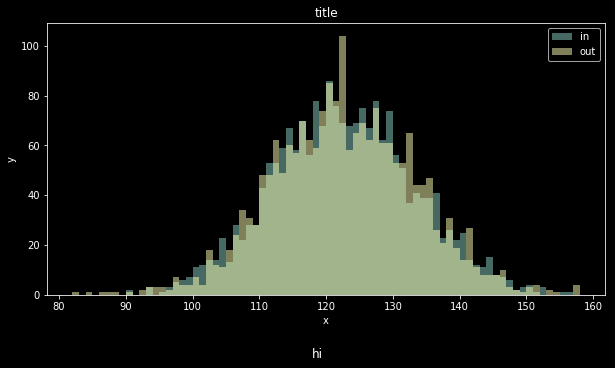

In [117]:
# Check if our network resembles a random network 

k = np.mean([value for key, value in list(G.degree())])
N = G.number_of_nodes()
p = k/(N-1)

ER = nx.erdos_renyi_graph(N, p, directed = True)

plt.figure(figsize = (10,5))

in_degree = [value for key, value in list(ER.in_degree())]
plt.hist(in_degree, bins=range(np.min(in_degree), np.max(in_degree)+1), alpha=0.5, label="in")

out_degree = [value for key, value in list(ER.out_degree())]
plt.hist(out_degree, bins=range(np.min(out_degree), np.max(out_degree)+1), alpha=0.5, label="out")

plt.title("title")
plt.ylabel("y")
plt.xlabel("x")
plt.legend()
plt.figtext(
    0.5, 
    -0.05, 
    'hi', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

As we can see, there is a big difference among the twitter network degree distribution and the distribution of a random network. In the Erdos-Renyi the in and out degree closely resembles a normal distribution.

To study how the different zodiac signs interact between eachother, we need to know how the zodiac signs iteracts with each sign. As explained above, the out-degree represents the interest of our user in another account, so we will be using that to meassure the interactions. As some users follow a lot of users and ohers don't follow anyone, the out-degree values are scaled to values between 0-1 based in how many conexion that sign has to the rest of the signs out of the total sum

## todo change this if we change to normalization

In [9]:
######THIS IS A COPY THAT WORKS WITH THE PERCENTAGE DO NOT DELETE

# Edge analysis

# TODO explain why some users follow 0, change to normalized values instead of %

zodiac = nx.get_node_attributes(G, 'zodiac')

out_degree_type = {}
out_degree_percentage = {}

# Iterate through nodes of all edges
for node in G.nodes():
    out_degree_type[node] = {}
    out_degree_percentage[node] = {}

    for sign in ZODIAC_SIGNS:
        out_degree_type[node][sign] = 0
    for node1, node2 in G.edges(node):
        out_degree_type[node][zodiac[node2]] +=1
    out_degree_type[node]['Total'] = sum(out_degree_type[node].values())  
    if out_degree_type[node]['Total'] != 0:
        for sign in ZODIAC_SIGNS:
            out_degree_percentage[node][sign] = out_degree_type[node][sign]/out_degree_type[node]['Total']
            #TODO: RENAME VARIABLE  
            #print(out_degree_type[node][sign])
            #if np.linalg.norm(out_degree_type[node][sign])  == 0:
            #    norm = out_degree_type[node][sign] 
            #else:
            #    norm =(out_degree_type[node][sign] / np.linalg.norm(out_degree_type[node][sign]))
            #out_degree_percentage[node][sign] = norm
                       
nx.set_node_attributes(G, out_degree_type, "out_degree_type")

In [10]:
sign_out_degree = {}
mean_sign_out_degree = {}
std_sign_out_degree = {}
out_sign_out_degree = {}


for sign1 in ZODIAC_SIGNS:
        sign_out_degree[sign1] = {}
        mean_sign_out_degree[sign1] = {}
        std_sign_out_degree[sign1] = {}
        out_sign_out_degree[sign1] = {}
        for sign2 in ZODIAC_SIGNS:
            sign_out_degree[sign1][sign2] = []
            
for node, val in out_degree_percentage.items():    
    for sign in ZODIAC_SIGNS:        
        try:
            sign_out_degree[zodiac[node]][sign].append(val[sign])
        except:
            pass

for sign1, val in sign_out_degree.items():
    for sign in ZODIAC_SIGNS: 
        mean_sign_out_degree[sign1][sign] = np.mean(val[sign])
        std_sign_out_degree[sign1][sign] = np.std(val[sign])
        out_sign_out_degree[sign1][sign] = val[sign]


We used box plots to study the relationship among the signs as they give out a lot of information:

 - The boxes represent the IQR (Interquartile Range), which are the the values that are situated between the 25% and 75% percentiles. This means that 50% of the values fall inside this range.


- The wiskers represent the maximum and minimum values excluding the outliers.

- The space between the end of the box and the wiskers represent the other 50% of the data, being this the lower quartile  at the bottom and upper quartile at the top

- The orange line represents the median. This indicates that 50% of the values are above that line and 50% below the line

- The datapoints outside the wiskers represent the outliers



In [ ]:
fig, subplots = plt.subplots(int(np.ceil(len(ZODIAC_SIGNS)/3)), 3, figsize=(15,20))
subplots = subplots.flatten()
fig.suptitle('Sentiment frequency distribution for each zodiac sign', y=1.01)
fig.tight_layout(pad=5.0)
#plt.xticks(rotation=45, ha='right')


for i, (key, value) in enumerate(out_sign_out_degree.items()):
    subplots[i].title.set_text(key)
    subplots[i].boxplot(list(value.values()), labels=ZODIAC_SIGNS) 
    subplots[i].tick_params(labelrotation=45)

    #subplots[sign_index].set_ylabel('Frequency')
    #subplots[sign_index].set_xlabel('Sentiment')

plt.figtext(
        0.5, 
        -0.05, 
        'TODO', 
        wrap=True, 
        horizontalalignment='center', 
        fontsize=12
) 
plt.show()

# todo explain some more
As we can see from our box plots, all the signs follow eachother in a quite similar way. 

We also studied the average out-degree of each sign to each sign

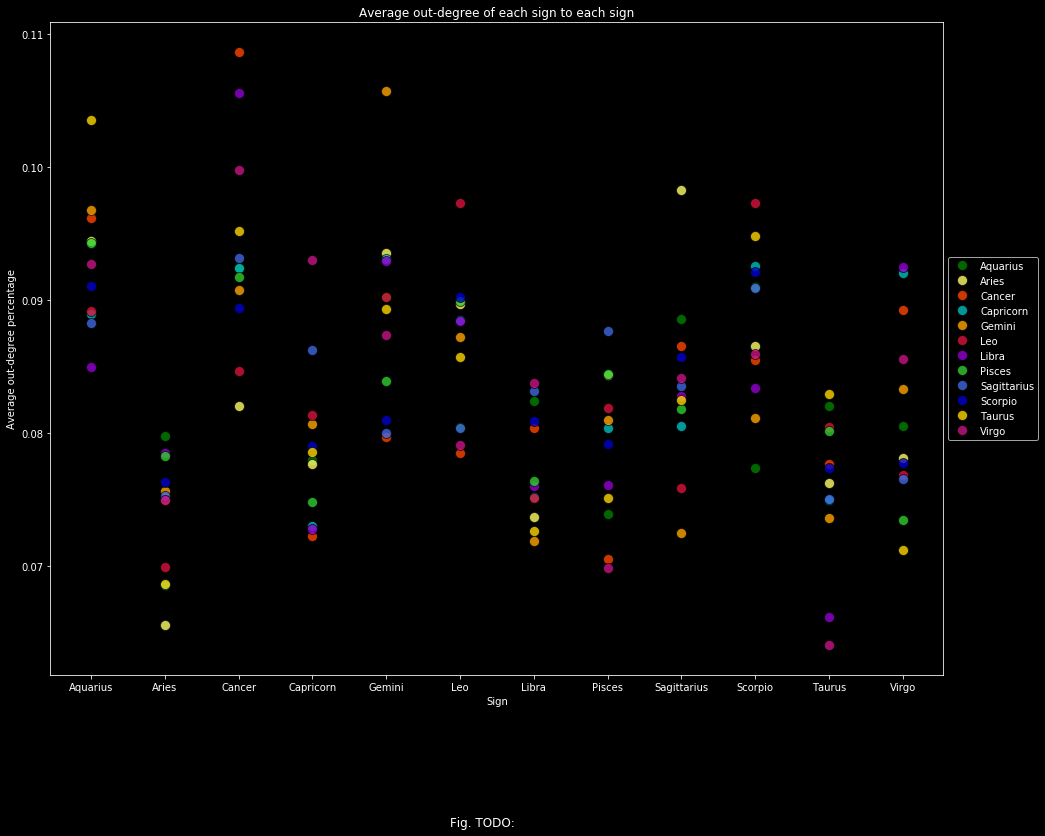

In [127]:
# TODO explain this plot
plt.figure(figsize = (16,12))

# Create legend
ax = plt.subplot(111)
# Put a legend to the right of the current axis
for sign1, mean in mean_sign_out_degree.items():
    #plt.errorbar(list(mean.keys()), list(mean.values()), yerr=std_sign_out_degree[sign1].values(), linewidth=1, fmt='o', capsize=7, ecolor=color_legend_zodiac[sign1], elinewidth=1, markersize=8, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)  
    plt.plot(list(mean.keys()), list(mean.values()), 'o', markersize=10, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title("Average out-degree of each sign to each sign")
plt.xlabel("Sign")
plt.ylabel("Average out-degree percentage")            
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO:', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

# todo explain this plot


The average out-degree percentage for each sign is mostly around 0.1. We can see how for Aries and Taurus is slightly smaller. 



Aquarius likes Aries
Aquarius hates Libra
Aries likes Aquarius
Aries hate Aries
Cancer like Cancer
Cancer hate Aries
Capricorn likes Virgo





Using the plot above we can try to make an "compatibility" chart where we can determine for each sign a high compatibility with the sign that has the higher average and low compatibility for the sign with the lowest average

In [63]:
compatibility_df = pd.DataFrame(columns=["Sign", "High", "Low"])
for sign, mean in mean_sign_out_degree.items():
    compatibility_df = compatibility_df.append({
     "Sign": sign, "High":  max(mean, key=mean.get),"Low": min(mean, key=mean.get)}, ignore_index=True)
    
compatibility_df

,Sign,High,Low
0,Aquarius,Aquarius,Pisces
1,Aries,Sagittarius,Aries
2,Cancer,Cancer,Pisces
3,Capricorn,Gemini,Aries
4,Gemini,Gemini,Libra
5,Leo,Scorpio,Aries
6,Libra,Cancer,Taurus
7,Pisces,Aquarius,Virgo
8,Sagittarius,Cancer,Taurus
9,Scorpio,Scorpio,Aries


To visualize the compatibility more clearly, we can create a network and plot it

In [90]:
C = nx.DiGraph()
C.add_nodes_from(compatibility_df.Sign)

# Set the attributes of the nodes
nx.set_node_attributes(C, dict(zip(compatibility_df.Sign, compatibility_df.High)), "high")
nx.set_node_attributes(C, dict(zip(compatibility_df.Sign, compatibility_df.Low)), "low")

high = nx.get_node_attributes(C,"high")
low = nx.get_node_attributes(C,"low")

# Create the links of the graph
high_edges = []
low_edges = []
for node in C.nodes():
    C.add_edge(node, high[node])
    C.add_edge(node, low[node])
    high_edges.append((node, high[node]))
    low_edges.append((node, low[node]))
    
# Display the network using forceAtlas
# Color the nodes based on the zodiac sign
node_color_zodiac = []
for node in C.nodes(data=True):
    node_color_zodiac.append(color_legend_zodiac[node[0]])

# Size the nodes based on their degree
#node_size = [v*0.5 for v in dict(C.degree).values()]

# Configure forceAtlas
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=1.0,

                        # Log
                        verbose=False)

# Obtain the positions
positions = forceatlas2.forceatlas2_networkx_layout(C, pos=None, iterations=50)

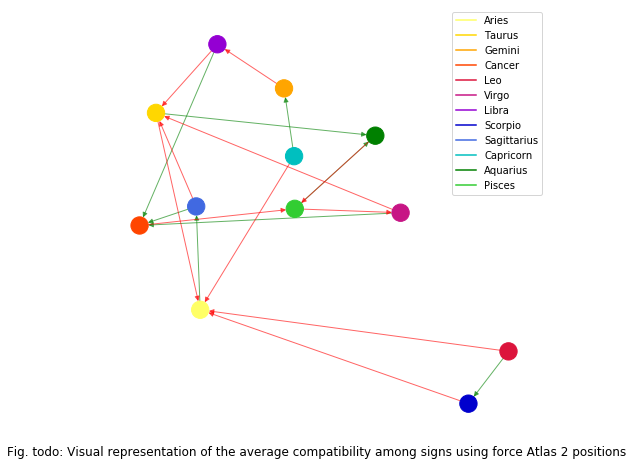

In [113]:
plt.figure(figsize = (8,8))

# Plot the graph
nx.draw_networkx_nodes(C, pos=positions, node_color=node_color_zodiac)

# Color the high compatibility in green
nx.draw_networkx_edges(C, pos=positions, alpha = 0.6, edgelist=high_edges, edge_color="green")

# Color the low compatibility in red
nx.draw_networkx_edges(C, pos=positions, alpha = 0.6, edgelist=low_edges, edge_color="red")

# Caption figure
plt.figtext(
    0.5, 
    0.1, 
    'Fig. todo: Visual representation of the average compatibility among signs using force Atlas 2 positions', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

for label in color_legend_zodiac:
    plt.plot([0],[0], color=color_legend_zodiac[label],label=label)
plt.legend()
plt.axis('off')
plt.show()


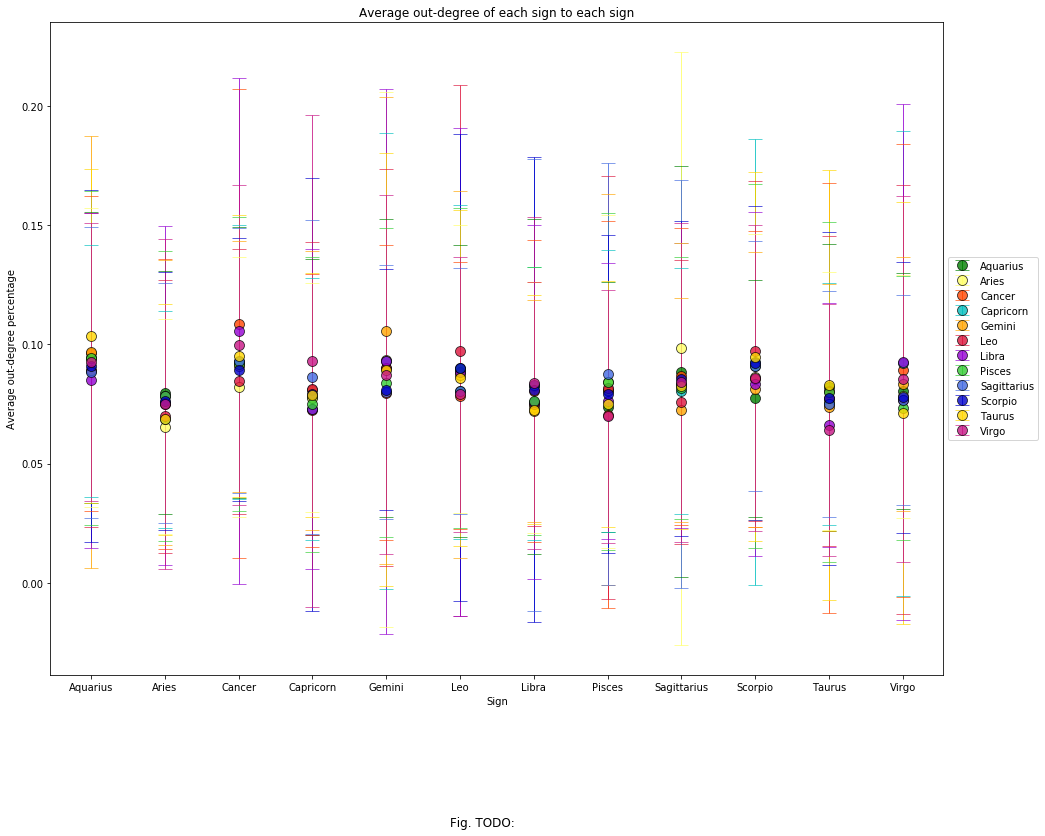

In [13]:
# TODO EXPLAIN THIS PLOT OR REMOVE

plt.figure(figsize = (16,12))

# Create legend
ax = plt.subplot(111)
# Put a legend to the right of the current axis
for sign1, mean in mean_sign_out_degree.items():
    plt.errorbar(list(mean.keys()), list(mean.values()), yerr=std_sign_out_degree[sign1].values(), linewidth=1, fmt='o', capsize=7, ecolor=color_legend_zodiac[sign1], elinewidth=1, markersize=10, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)  
    #plt.plot(list(mean.keys()), list(mean.values()), 'o', markersize=8, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.title("Average out-degree of each sign to each sign")
plt.xlabel("Sign")
plt.ylabel("Average out-degree percentage")            
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO:', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

In [115]:
# TODO explain this plot # TODO remove
plt.figure(figsize = (16,10))

# Create legend
ax = plt.subplot(111)
# Put a legend to the right of the current axis
for element, mean in mean_element_out_degree.items():
    plt.errorbar(list(mean.keys()), list(mean.values()), yerr=std_element_out_degree[element].values(), linewidth=1, fmt='o', capsize=7,  elinewidth=1, markersize=10, label = element, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)  
    #plt.plot(list(mean.keys()), list(mean.values()), 'o', markersize=8, color = color_legend_zodiac[sign1], label = sign1, markeredgewidth=0.8, markeredgecolor='k', alpha=0.8)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("Average out-degree of each sign to each sign")
plt.xlabel("Sign")
plt.ylabel("Average out-degree percentage")            
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO:', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

In [ ]:
# TODO check the distribution for each sign/element

### Content Analysis

As the astrology says, some signs tend to be more sensible than others. We analyze the tweets from our uses to ...

### todo: something about afinn why we use it etc

In [24]:
# load AFINN words
afinn_words = dict(map(lambda kv: (kv[0],int(kv[1])), 
                     [ line.split('\t') for line in open("./AFINN/AFINN-111.txt") ]))

Tokenization of the tweets. As we the users from our network come from all parts of the world, their tweets are in many different languages. Since we want to analyze the content of their tweets, we are going to keep only those tweets that contains words in english. To do so, we are usin nltk words dictionary that contains up to ?????? english words and the words from afinn as they include some twitter slang. Apart from that, we want to remove the stopwords from the most spoken languages, as some of this words also appear in the english dictionary we created, but the users who tweet them use them in other languages.

#todo talk about how twitter queries tweets (adding the tweet link, unfinished words with ... )

The Twitter API has a method to query tweets (see ./Datagathering.ipynb to know how the tweets are gathered). The tweets are given in a Tweet object. This object contains different information about the tweet, like the a link to the tweet, the text, the user, etc. If the tweet is to long, the text field contains only part of the tweet and leaves unfinished words.

To clean the tweets, we also removed the link to the tweet and all those unfinished words.

Althought analyzing the hashtags would have been quite interesting, due to the variety of languages of our dataset, we could not extract meaningful content for our analysis, so we decided to remove them as well.

In [25]:
# Tokenize the tweets to add them as node attributes

# Define stopwords from the most common languages
stopwords = sw.words('english') + sw.words('spanish') + sw.words('portuguese') + sw.words('french')

# Define the english words to use
englishwords = words.words() + list(afinn_words.keys())

tokenizer = WhitespaceTokenizer()
tokens_dict = {}

for node in df.Handle:
    tweets = df.loc[df['Handle'] == node].Tweets.values
    tweet_words = ' '.join(tweets)
      
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    raw = pattern.sub('', tweet_words)
    raw = raw.replace('\\n',' ')
    raw = raw.replace('\\',' ')
    raw = raw.replace('=',' ')
    raw = raw.replace('/',' ')
    raw = raw.replace('(',' ')
    raw = raw.replace(')',' ')
    raw = raw.replace(',',' ')
    raw = raw.replace('.',' ')
    raw = raw.lower()
       
    
    tweet_words = tokenizer.tokenize(raw)
    
    # Remove stopwords and non-english words
    tweet_words = [word for word in tweet_words if (word not in stopwords and word in englishwords)]
    
    # Remove hashtags
    tweet_words = [word for word in tweet_words if word[0] != '#']
    
    tokens_dict[node] = tweet_words   

Once we have all the tokens, we save them as node atributes as we will be using them often in our analysis.

In [26]:
nx.set_node_attributes(G, tokens_dict, "tokens")  

To create word clouds for each zodiac sign, we are obtaining the TF-IDF.

The Term Frequency is simply calculated by the raw number of occurrences of a word in a document.

$tf(t,d) = f_{t,d}$



In [27]:
# Get the term frequency for our communities zodiac signs

words = set()

# Create documents with the words of each character in each sign
documents = {}

# Compile term frequencies for each sign
tf = {}

tokens = nx.get_node_attributes(G, 'tokens')
zodiacs = nx.get_node_attributes(G, 'zodiac').items()

for zodiac in ZODIAC_SIGNS:
    nodes = [x for x, y in zodiacs if y==zodiac]
    
    document = []
    for user in nodes:
        document = document + tokens[user]
    words.update(document)
    documents[zodiac] = document
    
    # Get the term frequency for the document
    tf[zodiac] = FreqDist(document) 


The Inverse Document Frequency is calculated by the logarithm of the division of the number of documents by the number of the documents that the word appears in.

$idf(t,D) = \log(\frac{N}{n_t})$

In [28]:
# Get the inverse document frequency for our zodiac signs

idf = {}

for word in words:
    nt = 0
    for _, doc in documents.items():
        if word in doc:
            nt +=1
    
    idf[word]= np.log(10/nt)

TF-IDF is the product of TF and IDF

In [29]:
# Get the TF-IDF for our zodiac signs
tf_idf = {}
for zodiac in ZODIAC_SIGNS:
    tf_idf[zodiac] = {}

    for word, termf in tf[zodiac].items() :
        tf_idf[zodiac][word] = termf * idf[word]


In [ ]:
# TODO REMOVE IF NOT NEEDED 
# SAVE USEFUL DATA
import pickle

with open('./datafiles/tf_idf.pickle', 'wb') as handle:
    pickle.dump(tf_idf, handle)
with open('./datafiles/idf.pickle', 'wb') as handle:
    pickle.dump(idf, handle)
with open('./datafiles/g.pickle', 'wb') as handle:
    pickle.dump(G, handle)
with open('./datafiles/tokens_dict.pickle', 'wb') as handle:
    pickle.dump(tokens_dict, handle)

In [ ]:
# TODO REMOVE IF NOT NEEDED 
# LOAD USEFUL DATA
import pickle

with open('./datafiles/tf_idf.pickle', 'rb') as handle:
    tf_idf = pickle.load(handle)
with open('./datafiles/idf.pickle', 'rb') as handle:
    idf = pickle.load(handle)
with open('./datafiles/g.pickle', 'rb') as handle:
    G = pickle.load(handle)
with open('./datafiles/tokens_dict.pickle', 'rb') as handle:
    tokens_dict = pickle.load(handle)


Once we have the TF-IDF we can plot word clouds that display the most relevant words. As we are working with zodiac signs, we created mask to shape the word clouds with the zodiac shapes.

In [ ]:
# Create a wordcloud for each sign
for zodiac in ZODIAC_SIGNS:
    fdist = tf_idf[zodiac]
    mask_zodiac = np.array(Image.open("./images/" + zodiac + ".png"))

    # Create the wordclouds with a transparent background and the shape of the zodiac sign
    wc_zodiacs = WordCloud(width=8000, height=5000, mode="RGBA", background_color = None, max_words=500, mask=mask_zodiac, collocations = False).generate_from_frequencies(fdist)

    # Color the wordcloud with the colors of the zodiac sign
    image_colors = ImageColorGenerator(mask_zodiac)

    # Plot the wordcloud
    plt.figure(figsize = (16,10))
    plt.imshow(wc_zodiacs.recolor(color_func=image_colors), interpolation='bilinear')
    plt.axis("off")
    
    # Save the wordcloud
    plt.tight_layout()
    plt.savefig("./images/" + zodiac + "_wordcloud.png", transparent=True)
    
    # Add caption to figure
    plt.title(zodiac + " wordcloud")
    plt.show()

    

# TODO: say something about the words shown in the wordclouds

### Communities analysis
So far we have only worked with the zodiac signs as a way to create different communities to analyze the network. However, this is not a proper scientific analysis as it can be interpreted as an arbitrary partitions . To find the real communities in our network, we used the Louvain Algorithm. 

# todo explain louvain algorithm??

In [30]:
# Communities

# Create communities, stored in partition dictionary
partition = community_louvain.best_partition(U)

# Count number of different community values
counts = Counter(partition.values())

print("There is a total of " + str(len(counts)) + " communities in our network")

There is a total of 10 communities in our network


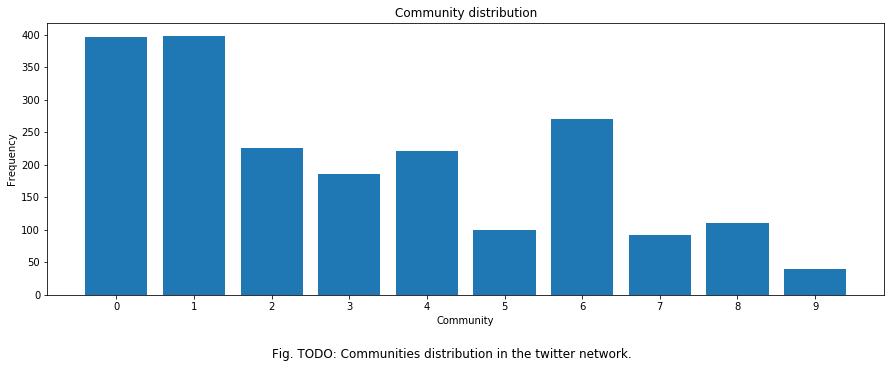

In [31]:
# Plot community distribution

# Store community values as list for histogram
communities = [value for key, value in partition.items()]
counts = Counter(communities)

# Create histrogram with a bin for each value in the community range (communities are integers)
plt.figure(figsize = (15,5))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()))

# Format plot
plt.title("Community distribution")
plt.ylabel("Frequency")
plt.xlabel("Community")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. TODO: Communities distribution in the twitter network.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)
plt.show()

In comparision with the zodiac distribution, we can see how the communities are not evenly distributed

# todo explain more

The astrology says that some signs tend to be more compatible with others. If this were true, we might be able to find inside our communities a strong presence of compatible signs inside the same communities. To check this, we plotted the zodiac distribution for each community

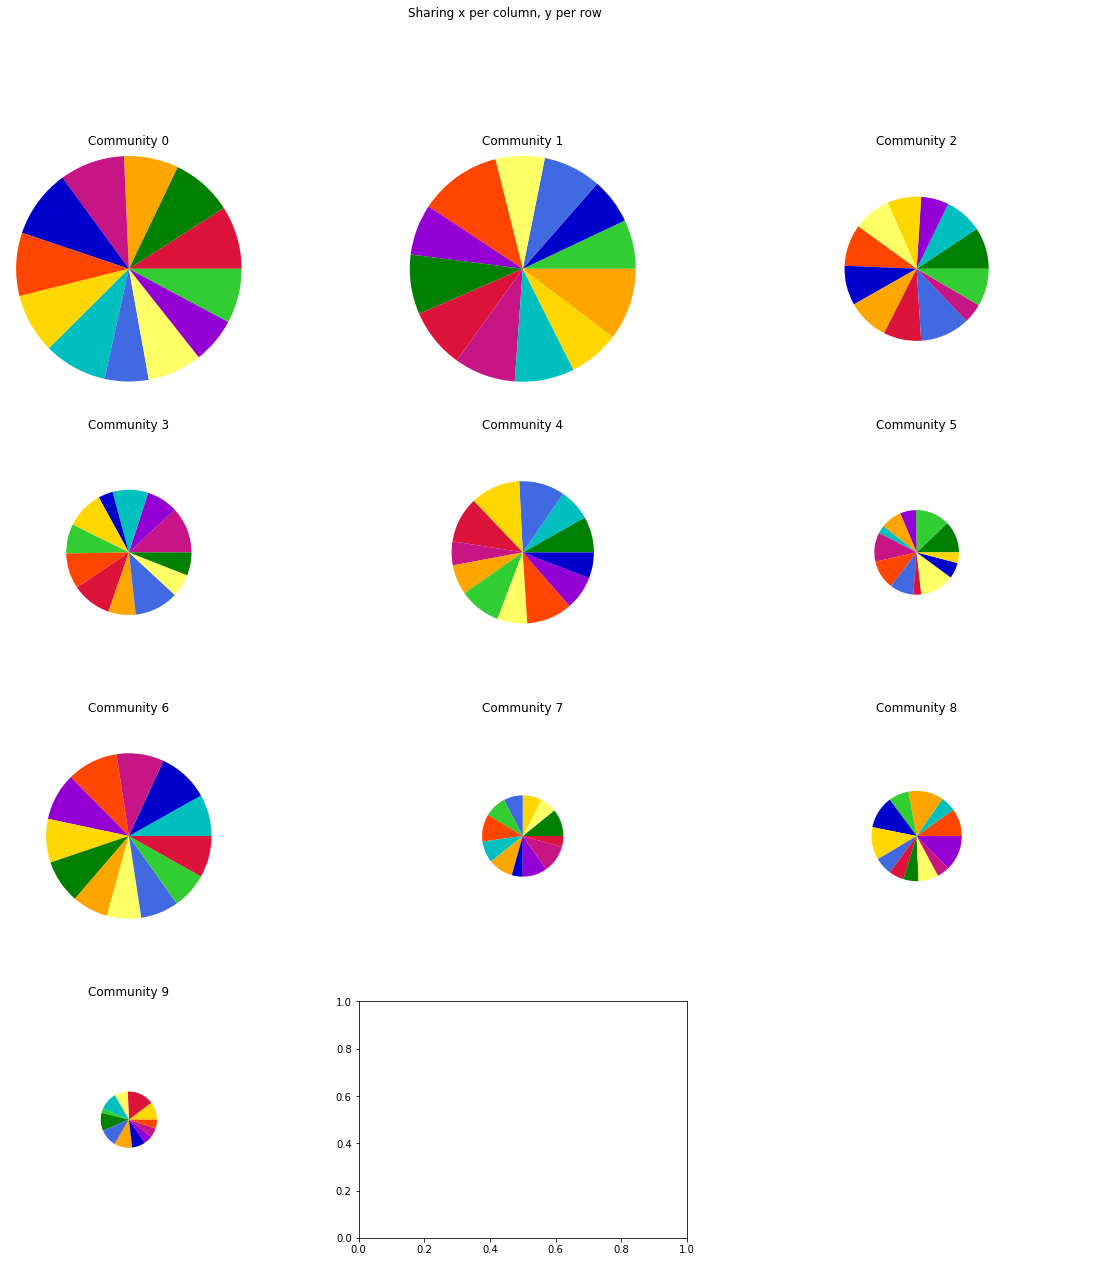

In [32]:
# Plot zodiac distribution inside each community
# TODO Remove axis at the end

communities = partition.items()
counts = Counter([value for key, value in communities])
zodiacs = nx.get_node_attributes(G, 'zodiac')

fig, subplots = plt.subplots(int(np.ceil(len(counts)/3)), 3, figsize=(20,20))

fig.suptitle('Sharing x per column, y per row')
#print(subplots)
subplots = subplots.flatten()
for comm in range(len(counts)):
    data = []
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:
        data.append(zodiacs[user])
    data_counts = Counter(data)
    #subplots[comm].title("Community "+ str(comm))
    #subplots[comm].figure(figsize = (16,16))
    subplots[comm].title.set_text("Community "+ str(comm))
    subplots[comm].pie(list(data_counts.values()), colors=[color_legend_zodiac[zodiac] for zodiac in data_counts.keys()], radius = 0.2+counts[comm]/400)         
    plt.axis("off")

plt.show()

The communities have been plotted with the size of their ?????. All the different colors inside the pie represent the zodiac signs. As we can see, all the communities show similar distributions of the signs. As expected, we can not tell any kind of compatibility among the signs. 

However, the signs can be grouped into 4 elements. The astrology also defends that even among the different elements, there is also some kind of compatibility. If this were true, finding the compatibility in the communities should be easier as there are less options????????  To check this, we plotted the element distribution inside each community.

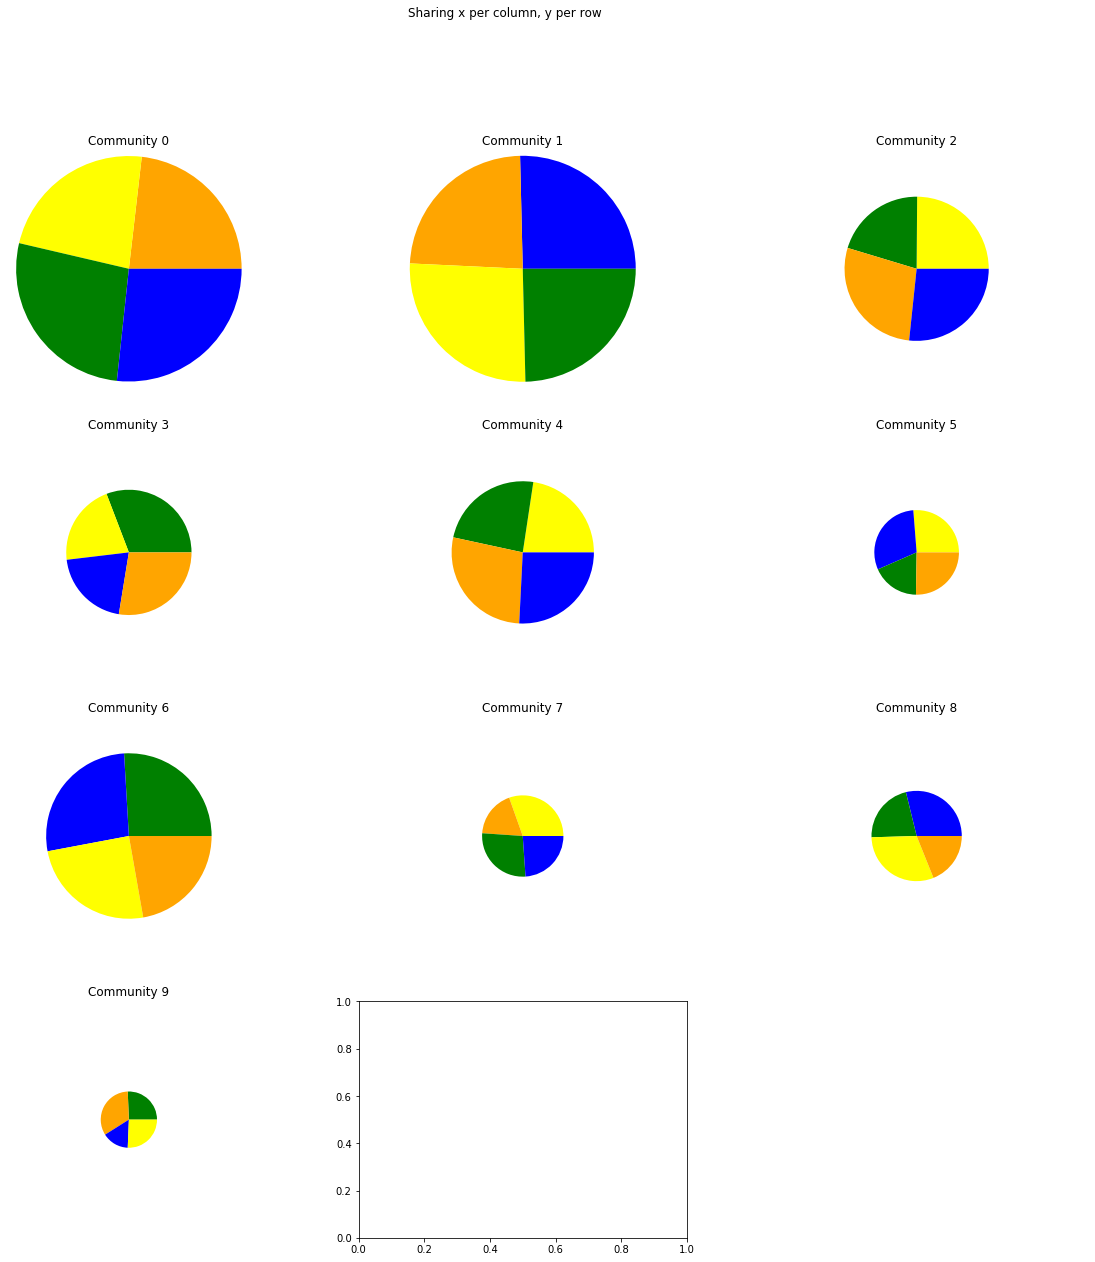

In [33]:
# Plot zodiac distribution inside each community
# TODO Remove axis at the end

communities = partition.items()
counts = Counter([value for key, value in communities])
elements = nx.get_node_attributes(G, 'element')


fig, subplots = plt.subplots(int(np.ceil(len(counts)/3)), 3, figsize=(20,20))

fig.suptitle('Sharing x per column, y per row')
#print(subplots)
subplots = subplots.flatten()
for comm in range(len(counts)):
    data = []
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:
        data.append(elements[user])
    data_counts = Counter(data)
    #subplots[comm].title("Community "+ str(comm))
    #subplots[comm].figure(figsize = (16,16))
    subplots[comm].title.set_text("Community "+ str(comm))
    subplots[comm].pie(list(data_counts.values()), colors=[color_legend_element[element] for element in data_counts.keys()], radius = 0.2+counts[comm]/400)         
    plt.axis("off")
plt.show()

As before, the communities have been plotted with the size of their ?????. This time, All the different colors inside the pie represent the elements. As we can see, all the communities show a even presence of each sign inside them. Again, as expected, we can not tell any kind of compatibility among the signs. 

The astrology deffends that there are some signs that tend to be more outgoing or extroverts. We want to check if this applies in our network by checking the 3 most popular users in our communities


#todo check and print the sign of the most popular users of each community

In [34]:
# Show the 3 most popular accounts in each community
communities = partition.items()
counts = Counter([value for key, value in communities])

for comm in range(len(counts)):
    user_popularity = {}
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:
        user_popularity[user] =  G.in_degree(user)
        #char_sentiment.append(sentiment_dict[char]
    sorted_user_popularity_community = sorted(user_popularity.items(), key=lambda x: x[1], reverse=True)
    print("Community ", comm, ": ", *sorted_user_popularity_community[:3])

Community  0 :  ('@barackobama', 752) ('@theellenshow', 637) ('@jimmyfallon', 551)
Community  1 :  ('@rihanna', 500) ('@ladygaga', 448) ('@justinbieber', 444)
Community  2 :  ('@jkcorden', 276) ('@victoriabeckham', 178) ('@gordonramsay', 172)
Community  3 :  ('@leodicaprio', 340) ('@priyankachopra', 125) ('@narendramodi', 124)
Community  4 :  ('@evalongoria', 207) ('@shakira', 185) ('@ricky_martin', 149)
Community  5 :  ('@paulocoelho', 228) ('@neymarjr', 143) ('@kaka', 122)
Community  6 :  ('@kanyewest', 357) ('@drake', 347) ('@kingjames', 330)
Community  7 :  ('@oprah', 463) ('@mannypacquiao', 80) ('@jason_mraz', 77)
Community  8 :  ('@queenrania', 85) ('@rterdogan', 43) ('@hhshkmohd', 41)
Community  9 :  ('@therock', 262) ('@rondarousey', 106) ('@johncena', 100)


The astrology deffends that there are some signs that tend to be more outgoing or extroverts. We want to check if this applies in our network by checking the 3 most popular users of each zodiac sign.


#todo check wich zodiac has the highest popularity (add the popularity of each user in that sign)

In [35]:
# Show the 3 most popular accounts in each zodiac
zodiacs = nx.get_node_attributes(G, 'zodiac').items()

for sign in ZODIAC_SIGNS:
    user_popularity = {}
    same_sign = [k for k,v in zodiacs if v == sign]
    for user in same_sign:
        user_popularity[user] =  G.in_degree(user)
        #char_sentiment.append(sentiment_dict[char]
    sorted_user_popularity_zodiac = sorted(user_popularity.items(), key=lambda x: x[1], reverse=True)
    print(sign, ": ", *sorted_user_popularity_zodiac[:3])

Aquarius :  ('@theellenshow', 637) ('@oprah', 463) ('@jtimberlake', 414)
Aries :  ('@ladygaga', 448) ('@pharrell', 289) ('@emmawatson', 269)
Cancer :  ('@elonmusk', 356) ('@tomhanks', 339) ('@arianagrande', 329)
Capricorn :  ('@ryanseacrest', 344) ('@kingjames', 330) ('@jimcarrey', 298)
Gemini :  ('@kanyewest', 357) ('@realdonaldtrump', 328) ('@andersoncooper', 258)
Leo :  ('@barackobama', 752) ('@jlo', 313) ('@ddlovato', 279)
Libra :  ('@kimkardashian', 313) ('@snoopdogg', 308) ('@kamalaharris', 307)
Pisces :  ('@rihanna', 500) ('@justinbieber', 444) ('@iamwill', 228)
Sagittarius :  ('@taylorswift13', 386) ('@chrissyteigen', 307) ('@sarahksilverman', 299)
Scorpio :  ('@katyperry', 412) ('@jimmykimmel', 349) ('@drake', 347)
Taurus :  ('@adele', 274) ('@therock', 262) ('@stephenathome', 244)
Virgo :  ('@jimmyfallon', 551) ('@pink', 262) ('@paulocoelho', 228)


# todo explain results 

### Sentiment analysis

We want to dig deeper into the analysis of the tweets of our users, as this might tell us something more about their personality. For that, we did a sentiment analysis using afinn


# todo explain better

In [36]:
def sentiment(tokens):
    try:
        return np.mean([afinn_words[token] for token in tokens if token in afinn_words.keys()])
    except:
        return 0

We obtained the sentiment for our users

In [37]:
tokens = nx.get_node_attributes(G, 'tokens').items()

user_sentiment = {}
for user, token_list in tokens:
    user_sentiment[user] = sentiment(token_list)

If what astrology says were true, with the sentiment analysis we could be able to see that some signs tend to be happier than others 

In [47]:
# Sentiment analysis for zodiac signs
zodiacs = nx.get_node_attributes(G, 'zodiac').items()

zodiac_sentiments = {}
mean_sentiments = {}
std_sentiments = {}

for sign in ZODIAC_SIGNS:
    zodiac_sentiments[sign] = []
    same_sign = [k for k,v in zodiacs if v == sign]
    for user in same_sign:
        zodiac_sentiments[sign].append(user_sentiment[user])
    mean_sentiments[sign] = np.nanmean(zodiac_sentiments[sign])
    std_sentiments[sign] = np.nanstd(zodiac_sentiments[sign])


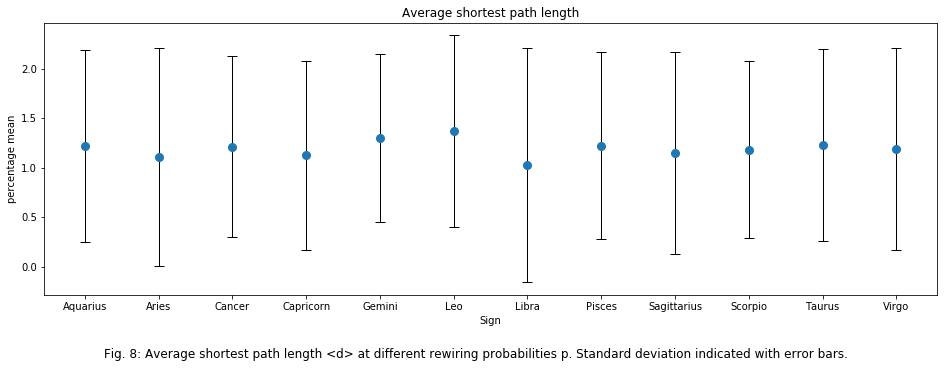

In [40]:
# Average sentiment for each zodiac

# TODO add colors
plt.figure(figsize = (16,5))
plt.errorbar(mean_sentiments.keys(), mean_sentiments.values(), yerr=std_sentiments.values(), 
             fmt='o', linewidth=1, capsize=5, ecolor='k', elinewidth=1, markersize = 8)
#print(markerfacecolor = [color_legend_zodiac[s] for s in list(mean_sentiments.keys())])
plt.title("Average shortest path length")
plt.xlabel("Sign")
plt.ylabel("percentage mean")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. 8: Average shortest path length <d> at different rewiring probabilities p. Standard deviation indicated with error bars.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

As we can see the average sentiment for the signs is quite similar. We can see some differences with Leo (Fire sign) being slightly more happy on average, and Libra (Air sign) slightly less happy. The afinn scale rates from -3 to 3, so stil Libra can be considered a happy sign

We can try to do the same calculations but this time compaing the average sentiment for in our communities

In [42]:
# Sentiment analysis for communities

communities = partition.items()
counts = Counter([value for key, value in communities])

community_sentiments = {}
mean_sentiments = {}
std_sentiments = {}

for comm in range(len(counts)):
    community_sentiments[comm] = []
    same_comm = [k for k,v in communities if v == comm]
    for user in same_comm:   
        community_sentiments[comm].append(user_sentiment[user])
    mean_sentiments[comm] = np.nanmean(community_sentiments[comm])
    std_sentiments[comm] = np.nanstd(community_sentiments[comm])
    
    

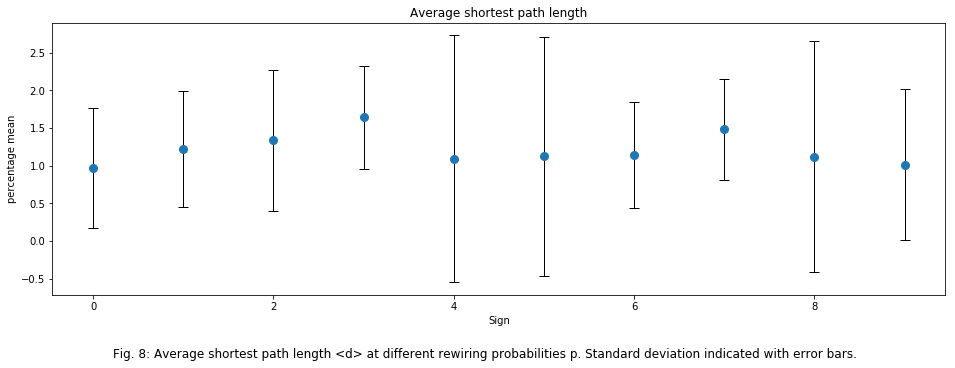

In [43]:
# Average sentiment for each community

# TODO add colors
plt.figure(figsize = (16,5))
plt.errorbar(mean_sentiments.keys(), mean_sentiments.values(), yerr=std_sentiments.values(), 
             fmt='o', linewidth=1, capsize=5, ecolor='k', elinewidth=1, markersize = 8)
#print(markerfacecolor = [color_legend_zodiac[s] for s in list(mean_sentiments.keys())])
plt.title("Average shortest path length")
plt.xlabel("Sign")
plt.ylabel("percentage mean")
plt.figtext(
    0.5, 
    -0.05, 
    'Fig. 8: Average shortest path length <d> at different rewiring probabilities p. Standard deviation indicated with error bars.', 
    wrap=True, 
    horizontalalignment='center', 
    fontsize=12
)

plt.show()

This time, we can tell more differences in the average sentiment of our communities. We can clearly identify community 3 as the happiest one. As the afinn scale rates from -3 to 3, we can not consider any sad community as all of them have an average sentiment above 1.

If we look at the sentiment frequency distribution we can see how mostly all o

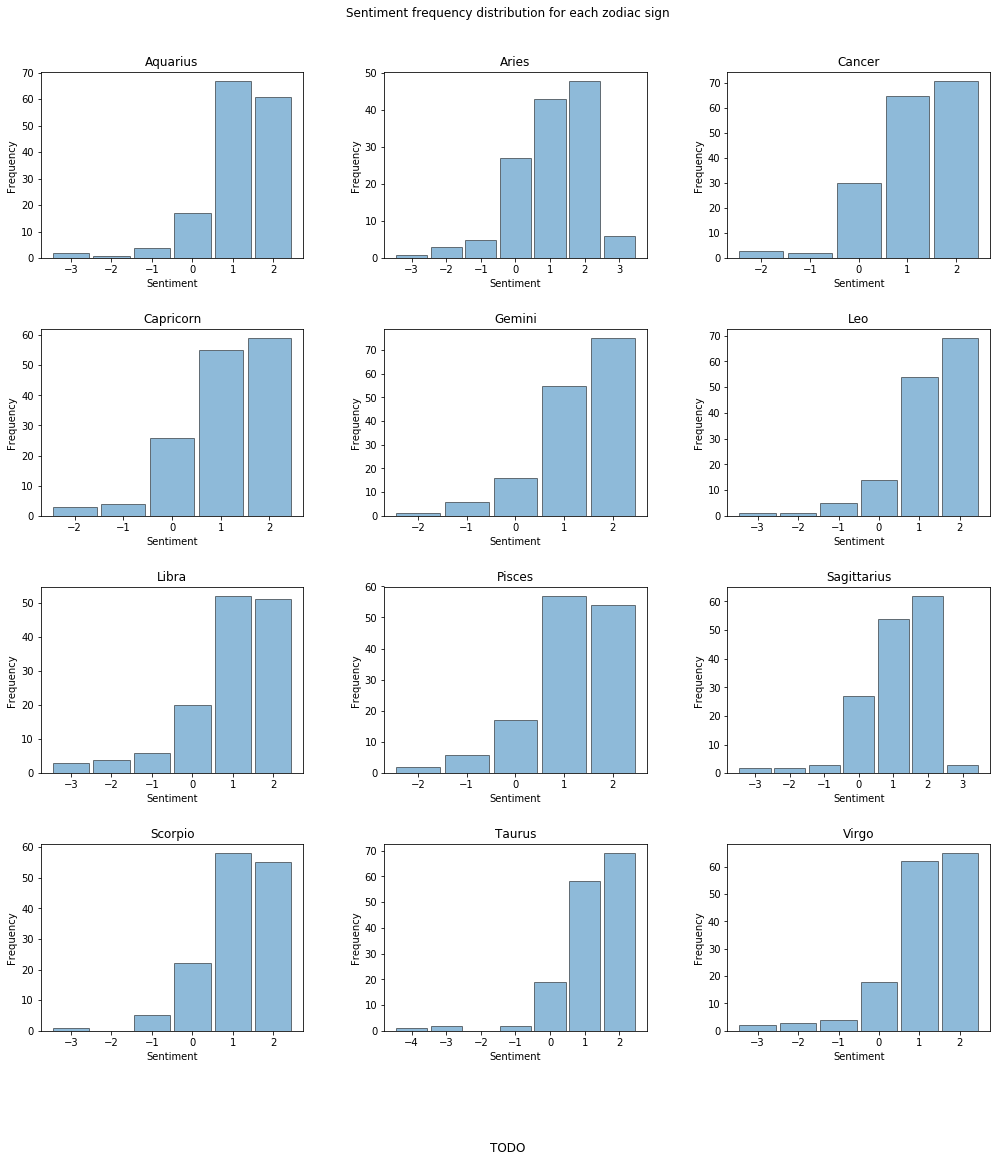

In [41]:
# Sentiment frequency distribution for each sign

fig, subplots = plt.subplots(int(np.ceil(len(ZODIAC_SIGNS)/3)), 3, figsize=(15,15))
subplots = subplots.flatten()
fig.suptitle('Sentiment frequency distribution for each zodiac sign', y=1.01)
fig.tight_layout(pad=5.0)
for sign_index in range(len(ZODIAC_SIGNS)):

    bins = np.arange(int(np.nanmin(zodiac_sentiments[ZODIAC_SIGNS[sign_index]])), int(np.nanmax(zodiac_sentiments[ZODIAC_SIGNS[sign_index]])+1))-0.5
    subplots[sign_index].title.set_text(ZODIAC_SIGNS[sign_index])
    subplots[sign_index].hist(zodiac_sentiments[ZODIAC_SIGNS[sign_index]], bins=bins, alpha=0.5, label="in", histtype='bar', ec='black', rwidth=0.9)         
    subplots[sign_index].set_ylabel('Frequency')
    subplots[sign_index].set_xlabel('Sentiment')

plt.figtext(
        0.5, 
        -0.05, 
        'TODO', 
        wrap=True, 
        horizontalalignment='center', 
        fontsize=12
)   
plt.show()

As we can see, the all the signs use more positive words in their tweets. We could interpret this as if there is no  big difference among the content the different zodiac signs tweet. However, but we need to keep in mind that most of the users in the network are public figures, and it makes sense that they use their twitter account to promote their content and therefore that they use more positive words than negative.

In [ ]:
#t-value: https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# Confidence interval: https://online.stat.psu.edu/stat415/lesson/2/2.6
p = 0.02

# yerr: shape(2,N): Separate - and + values for each bar.
# First row contains the lower errors, the second row contaRins the upper errors.


# remove ??


In [ ]:
# todo If we take the previous analysis to our communities we 

In [1]:
# Sentiment frequency distribution for each community

communities = partition.items()
counts = Counter([value for key, value in communities])

fig, subplots = plt.subplots(int(np.ceil(len(counts)/3)), 3, figsize=(15,15))
subplots = subplots.flatten()
fig.suptitle('Sentiment frequency distribution for each zodiac sign', y=1.01)
fig.tight_layout(pad=5.0)

for comm_index in range(len(counts)):
    bins = np.arange(int(np.nanmin(community_sentiments[comm_index])), int(np.nanmax(community_sentiments[comm_index])+1))-0.5
    subplots[comm_index].title.set_text(comm_index)
    subplots[comm_index].hist(community_sentiments[comm_index], bins=bins, alpha=0.5, label="in", histtype='bar', ec='black', rwidth=0.9)         
    subplots[comm_index].set_ylabel('Frequency')
    subplots[comm_index].set_xlabel('Sentiment')

plt.figtext(
        0.5, 
        -0.05, 
        'TODO', 
        wrap=True, 
        horizontalalignment='center', 
        fontsize=12
)   
plt.show()

NameError: name 'partition' is not defined

# todo explain frequency distribution for each community

## 4. Discussion

## 5. Contributions

The table bellow will provide a better overview on who took care of each part.

| Sub Chapter || Member's name |
  |-----|-------|------| 

# todo conclusion